In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%config InlineBackend.figure_format = 'svg'

from tqdm.notebook import tqdm

import pickle

# Preparing algorithms and data

In [2]:
from typing import Any


class ConstantPredictor:
    def __init__(
            self,
            method: str = 'mean'
    ):
        self.method = method
        if self.method not in {'mean', 'zero'}:
            raise ValueError(f'Expected "method" to be one of {"mean", "zero"}, '
                             f'got {method}')
        self._pred_val = None
        self._fitted = False

    def fit(
            self,
            *,
            y: Any = None
    ):
        """
        :param y: target vector, needed if method is 'mean'
        :return: fitted ConstantPredictor object
        """
        if (self.method == 'mean') and (y is None):
            raise ValueError('"mean" method is not supported if y is None')
        if self.method == 'mean':
            self._pred_val = y.mean()
        elif self.method == 'zero':
            self._pred_val = 0.
        self._fitted = True
        return self

    def predict(self, X):
        """
        :param X: Used to determine the length of prediction vector
        :return: constant-valued prediction vector
        """
        if not self._fitted:
            raise RuntimeError('Estimator is not fitted')
        return np.full(X.shape[0], self._pred_val)


class BaseEstimatorUtils:
    def __init__(
            self,
            random_state: int = 42,
            trace_loss: bool = False,
            trace_time: bool = False
    ):
        self.random_state = random_state
        self.trace_loss_ = trace_loss
        self.trace_time_ = trace_time

        self.train_loss_ = []
        self.val_loss_ = None
        self.time_spent_ = []

        self._fitted = False

    def _set_fitted(self):
        self._fitted = True

    def _check_if_fitted(self):
        if not self._fitted:
            raise RuntimeError('Estimator is not fitted!')
        return self._fitted

    def append_train_loss(self, loss_value):
        """Adds loss on train data to the storage array
        """
        if isinstance(loss_value, float):
            self.train_loss_.append(loss_value)
        else:
            self.train_loss_.extend(loss_value)

    def append_val_loss(self, loss_value):
        """Adds loss on validation data to the storage array
        """
        if self.val_loss_ is None:
            self.val_loss_ = []
        if isinstance(loss_value, float):
            self.val_loss_.append(loss_value)
        else:
            self.val_loss_.extend(loss_value)

    def append_time_(self, t):
        if isinstance(t, float):
            self.time_spent_.append(t)
        else:
            self.time_spent_.extend(t)


In [3]:
import threading
import time
from typing import Union, Literal

from joblib import Parallel, delayed
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor


class BootstrappedTrees:
    """Holder for trees and their feature and object subspaces
    """

    def __init__(self):
        self.trees_ = []
        self.bags_ = []
        self.subspaces_ = []

    @property
    def trees(self):
        """Getter for 'trees' field
        """
        return self.trees_

    @trees.setter
    def trees(self, value):
        """Setter for 'trees' field
        """
        self.trees_ = value

    @property
    def bags(self):
        """Getter for 'bags' field
        """
        return self.bags_

    @bags.setter
    def bags(self, value):
        """Setter for 'bags' field
        """
        self.bags_ = value

    @property
    def subspaces(self):
        """Getter for 'subspaces' field
        """
        return self.subspaces_

    @subspaces.setter
    def subspaces(self, value):
        """Setter for 'subspaces' field
        """
        self.subspaces_ = value


class BaseTreeEnsemble(BaseEstimatorUtils):
    def __init__(
            self,
            n_estimators,
            *,
            random_state: int = 42,
            base_tree,
            feature_subsample_size,
            max_samples,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        super().__init__(
            random_state=random_state,
            trace_loss=trace_loss,
            trace_time=trace_time
        )
        if n_estimators <= 0:
            raise ValueError(f'n_trees should be positive integer, got {n_estimators}')
        self.n_estimators = n_estimators
        self.base_tree_ = base_tree
        self.trees_parameters = trees_parameters
        self.feature_subsample_size = feature_subsample_size
        if isinstance(feature_subsample_size, float)\
                and ((feature_subsample_size > 1.) or (feature_subsample_size < 0.)):
            raise ValueError(f'Expected "feature_subsample_size" to be in [0., 1.], '
                             f'got {feature_subsample_size}')
        self.max_samples = max_samples

        self.estimators_ = BootstrappedTrees()

    def _set_params_fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        if self.feature_subsample_size == 'auto':
            self.feature_subsample_size = max(
                int(np.floor(X.shape[1] / 3)),
                1
            )
        else:
            self.feature_subsample_size = max(
                int(np.floor(self.feature_subsample_size * X.shape[1])),
                1
            )

        if self.max_samples == 'auto':
            bag_size = int(max(
                (1 - (1 - 1 / X.shape[0]) ** X.shape[0]) * X.shape[0],
                1
            ))
        else:
            bag_size = int(self.max_samples * X.shape[0])

        self.estimators_.bags = np.random.choice(
            X.shape[0],
            (self.n_estimators, bag_size),
            replace=True
        )

        self.estimators_.subspaces = [np.random.choice(
            X.shape[1],
            self.feature_subsample_size,
            replace=False
        ) for _ in range(self.n_estimators)]

    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        raise NotImplementedError

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        raise NotImplementedError

    def score(self, X, y, squared=True):
        """Compute MSE on given data
        """
        diff = self.predict(X) - y
        mse = 1 / len(y) * np.inner(diff, diff)
        if squared:
            return mse
        return np.sqrt(mse)


class RandomForestMSE(BaseTreeEnsemble):
    def __init__(
            self,
            n_estimators: int,
            *,
            feature_subsample_size: Union[Literal['auto'], float] = 'auto',
            max_samples: Union[Literal['auto'], float] = 'auto',
            random_state: int = 42,
            n_jobs: Union[None, int] = None,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If 'auto' then use one-third of all features.
        """

        super().__init__(
            n_estimators=n_estimators,
            random_state=random_state,
            base_tree=DecisionTreeRegressor,
            feature_subsample_size=feature_subsample_size,
            max_samples=max_samples,
            trace_loss=trace_loss,
            trace_time=trace_time,
            **trees_parameters
        )
        self.n_jobs = n_jobs

    @staticmethod
    def _parallel_predict(pred_fn, X, out, lock, partial=False):
        pred = pred_fn(X)
        with lock:
            if not partial:
                out[0] += pred
            else:
                out.append(pred)

    def _partial_predictions(self, X):
        self._check_if_fitted()

        pred = []
        lock = threading.Lock()
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
            require='sharedmem'
        )(delayed(self._parallel_predict)(
            tree.predict,
            X.take(self.estimators_.subspaces[idx], 1),
            pred,
            lock,
            True
        ) for idx, tree in enumerate(self.estimators_.trees))

        return np.cumsum(pred, axis=0) / np.arange(1, self.n_estimators + 1)[:, None]

    def _fit_tree(self, X, y, idx, lock=None):
        t0 = time.time()
        self.estimators_.trees[idx].fit(
            X.take(self.estimators_.bags[idx], 0).take(self.estimators_.subspaces[idx], 1),
            y[self.estimators_.bags[idx]]
        )
        t0 = time.time() - t0

        if self.trace_time_:
            if lock is not None:
                with lock:
                    self.append_time_(t0)
            else:
                raise ValueError('Expected Lock object to trace time')

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        X_val : numpy ndarray
            Array of size n_val_objects, n_features
        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self._set_params_fit(X)
        self._set_fitted()

        self.estimators_.trees = [self.base_tree_(
            **self.trees_parameters,
            random_state=np.random.randint(np.iinfo(np.int32).max)
        ) for _ in range(self.n_estimators)]

        lock = threading.Lock() if self.trace_time_ else None
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
        )(delayed(self._fit_tree)(X, y, idx, lock) for idx in range(self.n_estimators))

        if self.trace_loss_:
            train_diff = self._partial_predictions(X) - y
            self.append_train_loss(
                np.sqrt(np.mean(train_diff ** 2, axis=1))
            )
            if (X_val is not None) and (y_val is not None):
                val_diff = self._partial_predictions(X_val) - y_val
                self.append_val_loss(
                    np.sqrt(np.mean(val_diff ** 2, axis=1))
                )

        return self

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self._check_if_fitted()

        pred = np.zeros((X.shape[0]), dtype=np.float64)
        lock = threading.Lock()
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
            require='sharedmem'
        )(delayed(self._parallel_predict)(
            tree.predict,
            X.take(self.estimators_.subspaces[idx], 1),
            [pred],
            lock
        ) for idx, tree in enumerate(self.estimators_.trees))

        pred /= self.n_estimators
        return pred


class GradientBoostingMSE(BaseTreeEnsemble):
    def __init__(
            self,
            n_estimators,
            *,
            learning_rate: float = 0.1,
            max_depth: int = 3,
            feature_subsample_size: Union[Literal['auto'], float] = 'auto',
            max_samples: float = 1.,
            random_state: int = 42,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        learning_rate : float
            Use alpha * learning_rate instead of alpha
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If 'auto' then use one-third of all features.
        """

        super().__init__(
            n_estimators=n_estimators,
            random_state=random_state,
            base_tree=DecisionTreeRegressor,
            feature_subsample_size=feature_subsample_size,
            max_samples=max_samples,
            max_depth=max_depth,
            trace_loss=trace_loss,
            trace_time=trace_time,
            **trees_parameters
        )

        self.learning_rate = learning_rate
        self._weights = []
        self._const_pred = None

    def _partial_predictions(self, X):
        self._check_if_fitted()

        tree_preds = [tree.predict(
            X.take(subspace, 1)
        ) for subspace, tree in zip(
            self.estimators_.subspaces,
            self.estimators_.trees
        )]

        return self._const_pred.predict(X) + self.learning_rate\
               * np.cumsum(np.multiply(np.array(self._weights)[:, None],
                                       tree_preds), axis=0)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        self._set_params_fit(X)
        self._set_fitted()

        self._const_pred = ConstantPredictor('mean').fit(y=y)

        curr_target = self._const_pred.predict(X)

        for idx in range(self.n_estimators):
            t0 = time.time() if self.trace_time_ else None

            self.estimators_.trees.append(self.base_tree_(**self.trees_parameters))
            self.estimators_.trees[idx].fit(
                X.take(self.estimators_.bags[idx], 0).take(self.estimators_.subspaces[idx], 1),
                (y - curr_target)[self.estimators_.bags[idx]]
            )

            if self.trace_time_:
                t0 = time.time() - t0
                self.append_time_(t0)

            pred = self.estimators_.trees[idx].predict(X.take(self.estimators_.subspaces[idx], 1))

            self._weights.append(minimize_scalar(
                lambda x, prediction, target: np.linalg.norm(
                    target + x * prediction - y
                ),
                bounds=(0,),
                args=(pred, curr_target)
            ).x)

            curr_target = curr_target + self.learning_rate * self._weights[idx] * pred

        if self.trace_loss_:
            train_diff = self._partial_predictions(X) - y
            self.append_train_loss(
                np.sqrt(np.mean(train_diff ** 2, axis=1))
            )
            if (X_val is not None) and (y_val is not None):
                val_diff = self._partial_predictions(X_val) - y_val
                self.append_val_loss(
                    np.sqrt(np.mean(val_diff ** 2, axis=1))
                )

        return self

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self._check_if_fitted()

        tree_preds = np.array([tree.predict(
            X.take(subspace, 1)
        ) for subspace, tree in zip(
            self.estimators_.subspaces,
            self.estimators_.trees
        )])

        return self._const_pred.predict(X) + self.learning_rate * np.dot(self._weights, tree_preds)


In [4]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '.'

!chmod 600 ./kaggle.json
!kaggle datasets download -d harlfoxem/housesalesprediction

zsh:1: command not found: kaggle


In [5]:
!unzip housesalesprediction.zip

Archive:  housesalesprediction.zip
replace kc_house_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
data = pd.read_csv('kc_house_data.csv')
data.drop('id', axis=1, inplace=True)
y = data.pop('price')

In [6]:
data.date = pd.to_datetime(data.date)

In [7]:
data.date = (data.date - data.date.min()).dt.days

In [8]:
data = pd.get_dummies(data, columns=['view'])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    data.to_numpy(), y.to_numpy(), test_size=.3, random_state=42
)

In [11]:
# data_train, X_test, target_train, y_test = train_test_split(
#     data.to_numpy(), y.to_numpy(), test_size=.3, random_state=42
# )

In [12]:
# X_train, X_val, y_train, y_val = train_test_split(
#     data_train, target_train, test_size=.2, random_state=0
# )

# Studying the RandomForest hyper-parameters

In [13]:
from itertools import product

In [ ]:
grid = {
    'feature_subsample_size': ['auto', .1, .75, 1.],
    'max_depth': [1, 3, 5, None],
    'max_samples': ['auto', .3, .75, 1.],
}

param_names = list(grid.keys())
raveled_grid = list(product(*list(grid.values())))

In [15]:
forest_hist = {}
forest_best_rmse = None
forest_best_params = None

for param_set in tqdm(raveled_grid):
    param_dict = dict(zip(param_names, param_set))
    model = RandomForestMSE(1000, **param_dict, trace_loss=True,
                            n_jobs=-1, trace_time=True)
    model.fit(X_train, y_train, X_val, y_val)
    curr_rmse = min(model.val_loss_)
    n_estimators = np.argmin(model.val_loss_) + 1
    forest_hist[param_set] = {
        'rmse': curr_rmse,
        'train loss': model.train_loss_,
        'val loss': model.val_loss_,
        'trees': n_estimators,
        'time': model.time_spent_
    }
    if (forest_best_rmse is None) or (curr_rmse < forest_best_rmse):
        print(f'Values = {param_set}, score = {curr_rmse}; {n_estimators} trees\n'
              f'\tFull score = {model.score(X_val, y_val, squared=False)}')
        forest_best_rmse = curr_rmse
        forest_best_params = param_set

  0%|          | 0/64 [00:00<?, ?it/s]

Values = ('auto', 1, 'auto'), score = 300844.0009542311; 152 trees
	Full score = 301587.47384076077
Values = ('auto', 1, 0.3), score = 299034.63551753317; 58 trees
	Full score = 300550.62856680696
Values = ('auto', 3, 'auto'), score = 236629.65955230372; 48 trees
	Full score = 239022.68275834207
Values = ('auto', 3, 0.3), score = 230304.77392814186; 14 trees
	Full score = 237618.93607428749


KeyboardInterrupt: 

In [18]:
if True:
    with open('forest_hist', 'wb') as f:
        pickle.dump(forest_hist, f)

In [16]:
with open('forest_hist', 'rb') as f:
    forest_hist = pickle.load(f)

In [17]:
forest_best_params = (0.75, None, 1.0)
forest_best_params

(0.75, None, 1.0)

In [21]:
forest_best_rmse

116113.67462047248

In [22]:
forest_hist[forest_best_params]['time']

[0.12221455574035645,
 0.13942313194274902,
 0.14513349533081055,
 0.14065194129943848,
 0.14371895790100098,
 0.15024471282958984,
 0.15085053443908691,
 0.15448832511901855,
 0.15959477424621582,
 0.16739344596862793,
 0.18227839469909668,
 0.18981194496154785,
 0.11719059944152832,
 0.11315345764160156,
 0.12446808815002441,
 0.12511253356933594,
 0.13705921173095703,
 0.1395268440246582,
 0.13031792640686035,
 0.13946008682250977,
 0.1170814037322998,
 0.12644028663635254,
 0.1886441707611084,
 0.11884713172912598,
 0.21387958526611328,
 0.11008262634277344,
 0.12410855293273926,
 0.1138768196105957,
 0.12586426734924316,
 0.12027287483215332,
 0.1300976276397705,
 0.11067008972167969,
 0.13823413848876953,
 0.163985013961792,
 0.14016985893249512,
 0.11213231086730957,
 0.12491869926452637,
 0.11022472381591797,
 0.16979765892028809,
 0.18198227882385254,
 0.15060663223266602,
 0.14161229133605957,
 0.15366435050964355,
 0.13492655754089355,
 0.15145611763000488,
 0.14495539665222

feature subsample size

In [19]:
names = list(filter(lambda x: (x[1] == forest_best_params[1]) and (x[2] == forest_best_params[2]), raveled_grid))
names

[('auto', None, 1.0), (0.1, None, 1.0), (0.75, None, 1.0), (1.0, None, 1.0)]

In [21]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +\
                ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'feature subsample size': str(name[0])
    }) for name in names], axis=0, ignore_index=True)

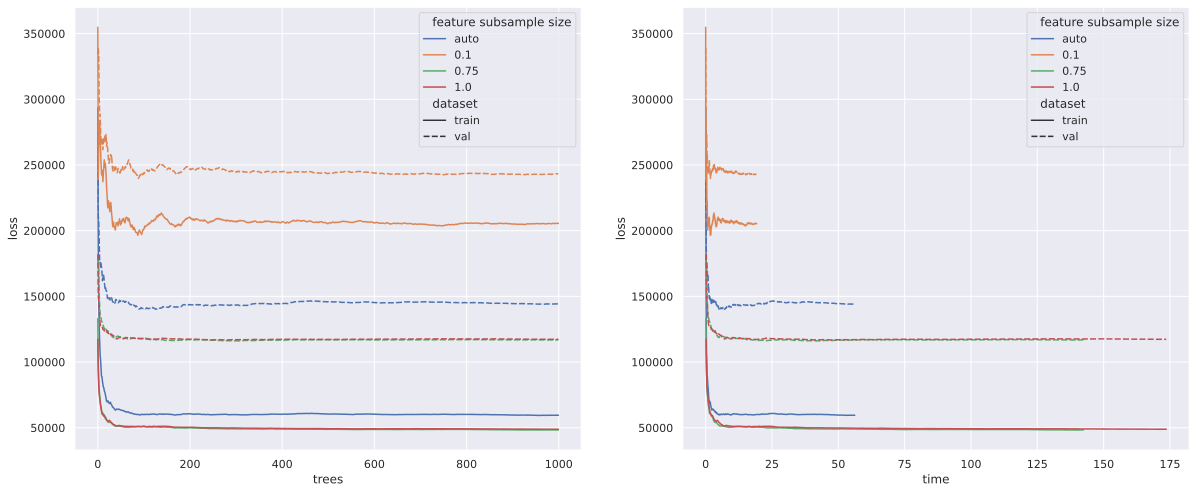

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='feature subsample size', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='feature subsample size', style='dataset', ax=ax[1])
plt.show()

max depth

In [23]:
names = list(filter(lambda x: (x[0] == forest_best_params[0]) and (x[2] == forest_best_params[2]), raveled_grid))
names

[(0.75, 1, 1.0), (0.75, 3, 1.0), (0.75, 5, 1.0), (0.75, None, 1.0)]

In [24]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +
                   ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'max depth': str(name[1])
    }) for name in names], axis=0, ignore_index=True)

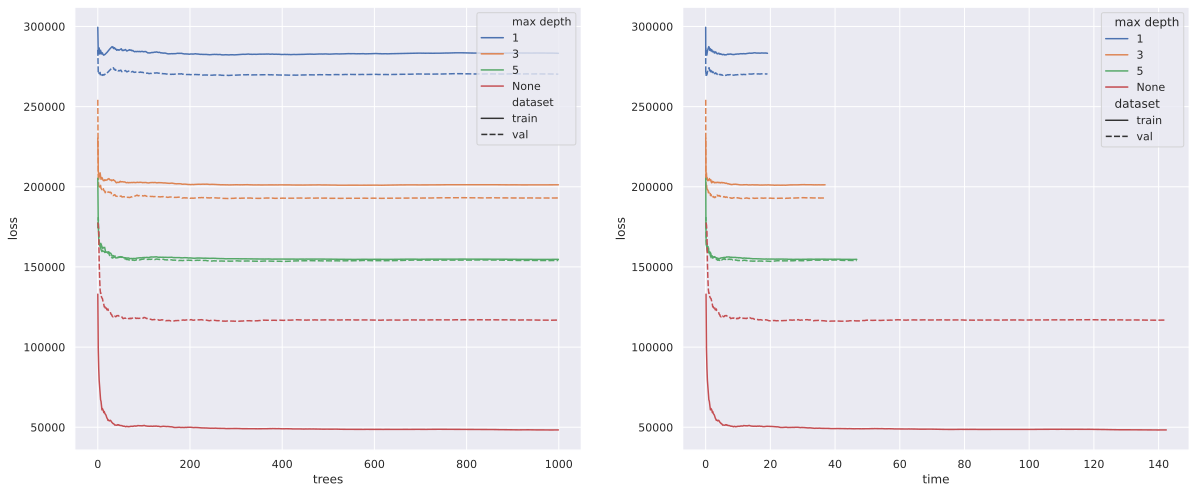

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max depth', style='dataset', ax=ax[0])
ax[0].legend(loc='upper right')
sns.lineplot(data=data, x='time', y='loss', hue='max depth', style='dataset', ax=ax[1])
plt.show()

max samples

In [28]:
names = list(filter(lambda x: (x[0] == forest_best_params[0]) and (x[1] == forest_best_params[1]), raveled_grid))
names

[(0.75, None, 'auto'),
 (0.75, None, 0.3),
 (0.75, None, 0.75),
 (0.75, None, 1.0)]

In [29]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +
                   ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'max samples': str(name[2])
    }) for name in names], axis=0, ignore_index=True)

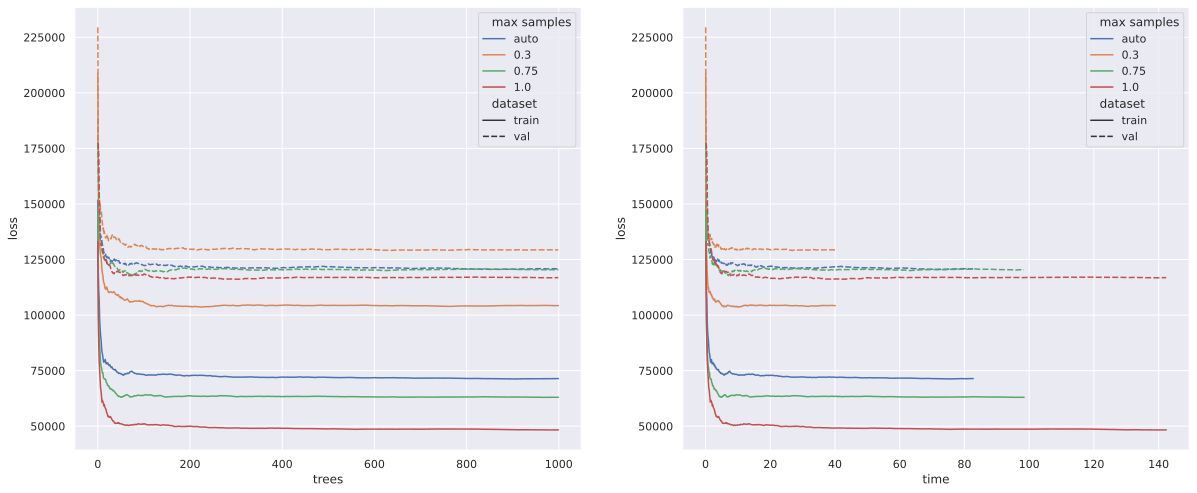

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max samples', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='max samples', style='dataset', ax=ax[1])
plt.show()

# Studying the GradientBoosting hyper-parameters

In [23]:
# for param_set in tqdm(raveled_grid):
#     param_dict = dict(zip(param_names, param_set))
#     model = GradientBoostingMSE(1000, **param_dict, trace_loss=True)
#     model.fit(X_train, y_train, X_test, y_test)
#     curr_rmse = min(model.val_loss_)
#     n_estimators = np.argmin(model.val_loss_)
#     boosting_hist[param_set] = (curr_rmse, model.train_loss_, model.val_loss_, n_estimators)
#     if (boosting_best_rmse is None) or (curr_rmse < boosting_best_rmse):
#         boosting_best_rmse = curr_rmse
#         boosting_best_params = param_set

In [40]:
grid = {
    'max_depth': [1, 3, 5, None],
    'learning_rate': [1e-1, 1e0, 1e-2, 1e-3],
    'feature_subsample_size': ['auto', .1, .75, 1.],
    'max_samples': ['auto', .3, .75, 1.],
}

boosting_hist = {}
boosting_best_rmse = None
curr_params = {k: v[0] for k, v in grid.items()}
boosting_best_params = curr_params.copy()
sl = slice(0, None, None)

for param in tqdm(grid.keys()):
    print(f'\nParameter {param}.')
    for param_value in tqdm(grid[param][sl]):
        curr_params[param] = param_value
        model = GradientBoostingMSE(1000, **curr_params,
                                    trace_loss=True, trace_time=True)

        model.fit(X_train, y_train, X_val, y_val)
        curr_rmse = min(model.val_loss_)
        n_estimators = np.argmin(model.val_loss_) + 1
        print(f'Value = {param_value}, score = {curr_rmse}; {n_estimators} trees\n'
              f'\tFull score = {model.score(X_val, y_val, squared=False)}')
        boosting_hist[tuple(curr_params.values())] = {
            'rmse': curr_rmse,
            'train loss': model.train_loss_,
            'val loss': model.val_loss_,
            'trees': n_estimators,
            'time': model.time_spent_
        }
        if (boosting_best_rmse is None) or (curr_rmse < boosting_best_rmse):
            boosting_best_rmse = curr_rmse
            boosting_best_params = curr_params.copy()
    sl = slice(1, None, None)
    print(f'!Best value = {boosting_best_params[param]}, '
          f'Score = {boosting_best_rmse}')
    curr_params[param] = boosting_best_params[param]

  0%|          | 0/4 [00:00<?, ?it/s]


Parameter max_depth.


  0%|          | 0/4 [00:00<?, ?it/s]

Value = 1, score = 178156.71475254744; 1000 trees
	Full score = 178156.71475254744
Value = 3, score = 136154.10178833624; 1000 trees
	Full score = 136154.10178833624
Value = 5, score = 128009.60455516887; 954 trees
	Full score = 128052.68568961184
Value = None, score = 158449.4008285161; 185 trees
	Full score = 158540.0278550438
!Best value = 5, Score = 128009.60455516887

Parameter learning_rate.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 1.0, score = 215381.65470469734; 12 trees
	Full score = 230076.80050685233
Value = 0.01, score = 137442.7536820586; 1000 trees
	Full score = 137442.75368205862
Value = 0.001, score = 246309.12724643547; 1000 trees
	Full score = 246309.12724643544
!Best value = 0.1, Score = 128009.60455516887

Parameter feature_subsample_size.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 0.1, score = 146172.10435470077; 993 trees
	Full score = 146184.56945611903
Value = 0.75, score = 130805.1529539896; 984 trees
	Full score = 130829.30739670426
Value = 1.0, score = 131030.6576979596; 969 trees
	Full score = 131049.62417476455
!Best value = auto, Score = 128009.60455516887

Parameter max_samples.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 0.3, score = 135705.242287588; 1000 trees
	Full score = 135705.24228758796
Value = 0.75, score = 125380.1614790067; 993 trees
	Full score = 125402.86973435672
Value = 1.0, score = 129751.70185855654; 988 trees
	Full score = 129790.33485534953
!Best value = 0.75, Score = 125380.1614790067


In [41]:
boosting_best_rmse

125380.1614790067

In [42]:
boosting_best_params

{'max_depth': 5,
 'learning_rate': 0.1,
 'feature_subsample_size': 'auto',
 'max_samples': 0.75}

In [43]:
boosting_best_params = {'max_depth': 5,
                        'learning_rate': 0.1,
                        'feature_subsample_size': 'auto',
                        'max_samples': 0.75}

In [44]:
if True:
    with open('boosting_hist', 'wb') as f:
        pickle.dump(boosting_hist, f)

In [39]:
with open('boosting_hist', 'rb') as f:
    boosting_hist = pickle.load(f)

In [28]:
boosting_hist[tuple(boosting_best_params.values())]['time']

[0.03268790245056152,
 0.03568768501281738,
 0.026605844497680664,
 0.03337574005126953,
 0.036568403244018555,
 0.03242921829223633,
 0.03554725646972656,
 0.0429997444152832,
 0.027447938919067383,
 0.027955055236816406,
 0.028821706771850586,
 0.03335881233215332,
 0.030698537826538086,
 0.03190875053405762,
 0.037314414978027344,
 0.03201460838317871,
 0.0323331356048584,
 0.03560280799865723,
 0.02791595458984375,
 0.03432440757751465,
 0.03151392936706543,
 0.033144474029541016,
 0.030415773391723633,
 0.03674006462097168,
 0.02931356430053711,
 0.03259110450744629,
 0.02832484245300293,
 0.03426074981689453,
 0.030142784118652344,
 0.034015655517578125,
 0.03214263916015625,
 0.03156638145446777,
 0.037915945053100586,
 0.03030109405517578,
 0.026276826858520508,
 0.038164377212524414,
 0.0281369686126709,
 0.033974647521972656,
 0.029729843139648438,
 0.03193497657775879,
 0.025935649871826172,
 0.02724003791809082,
 0.03162074089050293,
 0.03592991828918457,
 0.030537128448486

In [26]:
keys = list(boosting_hist.keys())

### max_depth

In [29]:
names = keys[:4]
names

[(1, 0.1, 'auto', 'auto'),
 (3, 0.1, 'auto', 'auto'),
 (5, 0.1, 'auto', 'auto'),
 (None, 0.1, 'auto', 'auto')]

In [234]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +\
                ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'depth': str(name[0])
    }) for name in names], axis=0, ignore_index=True)

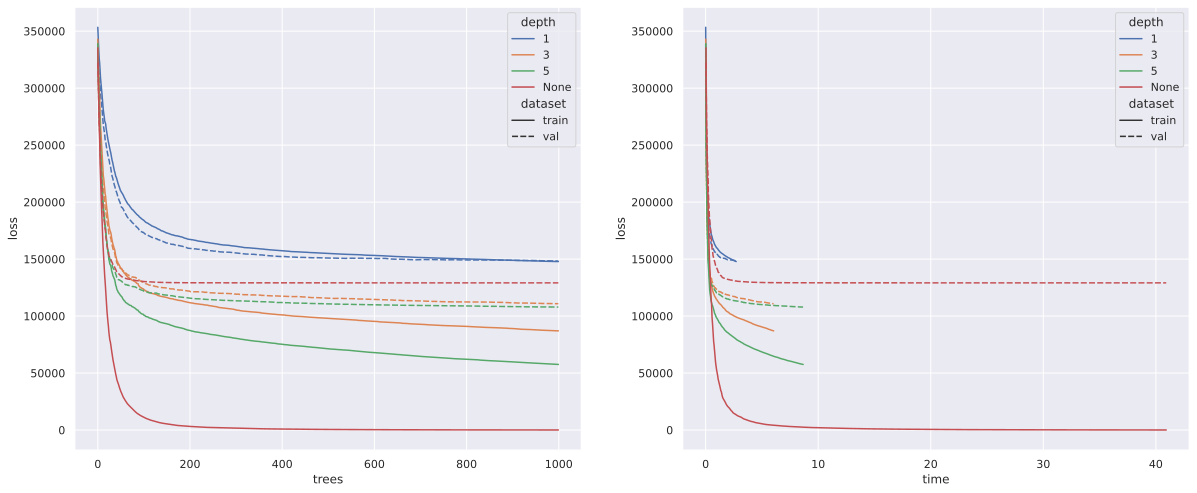

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='depth', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='depth', style='dataset', ax=ax[1])
plt.show()

### learning rate

In [31]:
names = keys[2:3] + keys[4:7]
names

[(5, 0.1, 'auto', 'auto'),
 (5, 1.0, 'auto', 'auto'),
 (5, 0.01, 'auto', 'auto'),
 (5, 0.001, 'auto', 'auto')]

In [32]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'learning rate': str(name[1])
    }) for name in names], axis=0, ignore_index=True)

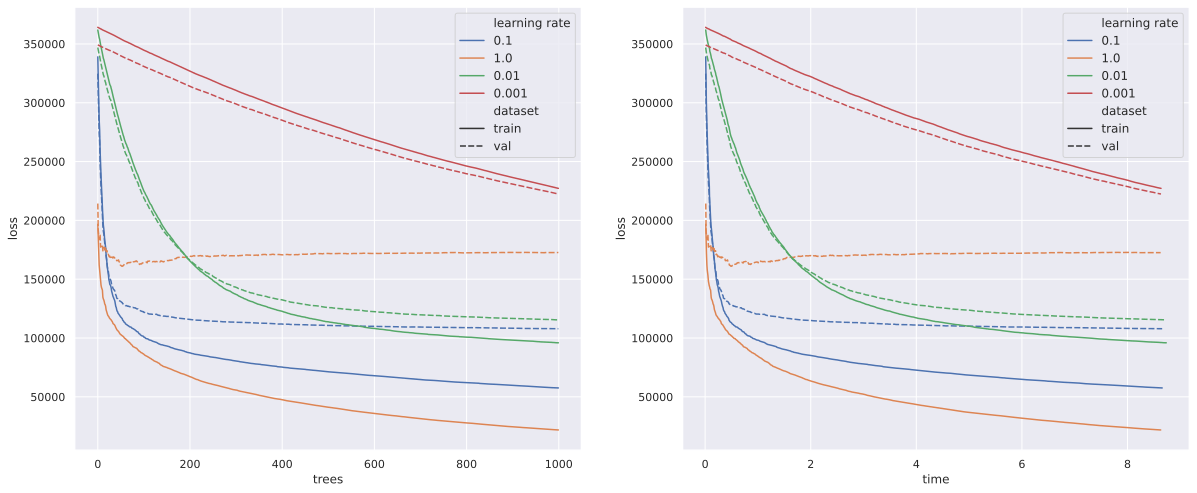

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='learning rate', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='learning rate', style='dataset', ax=ax[1])
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

### feature subsample size

In [239]:
names = keys[2:3] + keys[7:10]
names

[(5, 0.1, 'auto', 'auto'),
 (5, 0.1, 0.1, 'auto'),
 (5, 0.1, 0.75, 'auto'),
 (5, 0.1, 1.0, 'auto')]

In [240]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'feature subsample size': str(name[2])
    }) for name in names], axis=0, ignore_index=True)

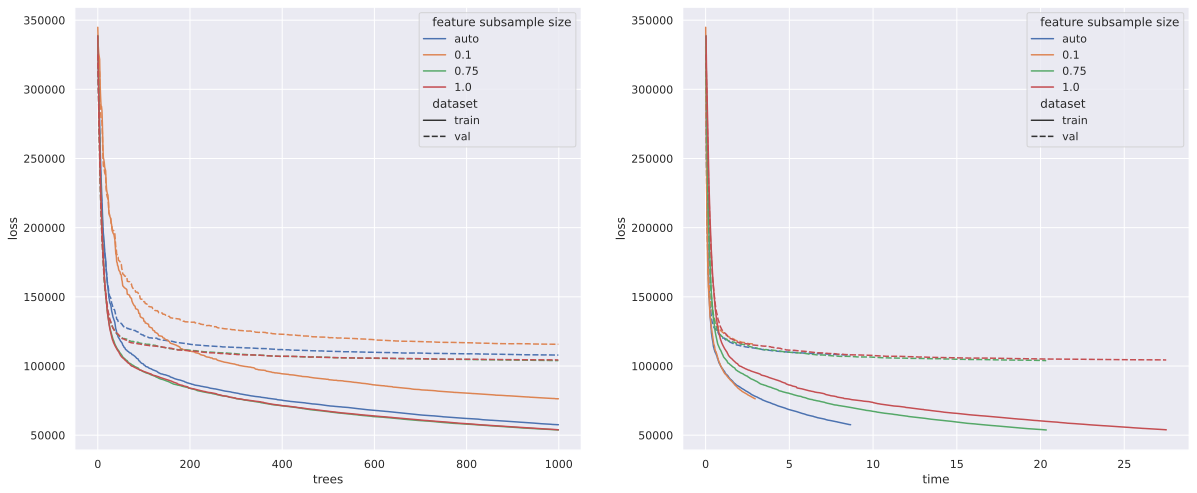

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='feature subsample size', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='feature subsample size', style='dataset', ax=ax[1])
plt.show()

### max samples

In [242]:
names = keys[9:10] + keys[10:]
names

[(5, 0.1, 1.0, 'auto'),
 (5, 0.1, 0.75, 0.3),
 (5, 0.1, 0.75, 0.75),
 (5, 0.1, 0.75, 1.0)]

In [243]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'max samples': str(name[-1])
    }) for name in names], axis=0, ignore_index=True)

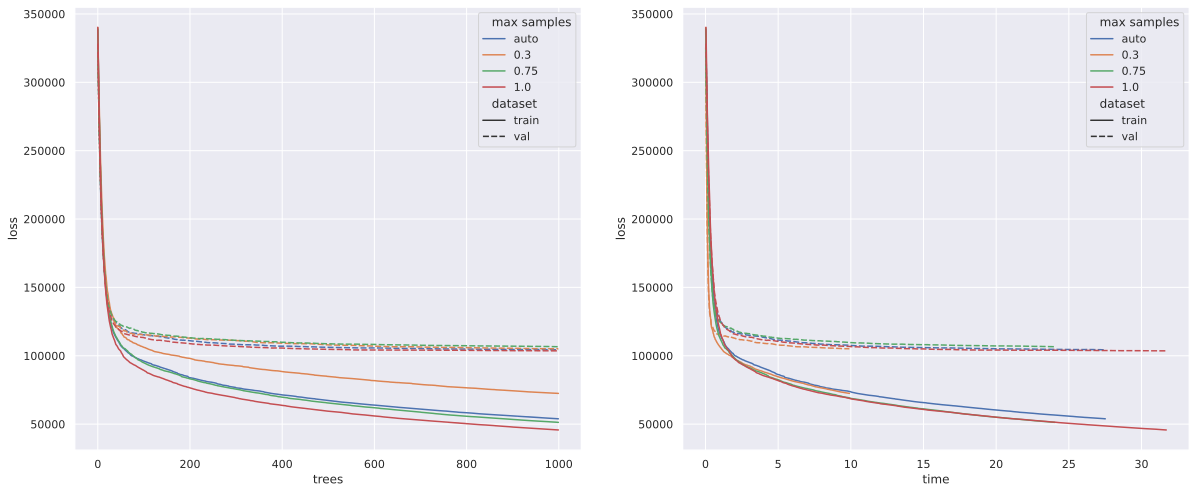

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max samples', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='max samples', style='dataset', ax=ax[1])
plt.show()